In [1]:
print("Hello World")

Hello World


0    54.28
1    54.44
2    53.99
3    52.59
4    51.68
Name: Price, dtype: float64


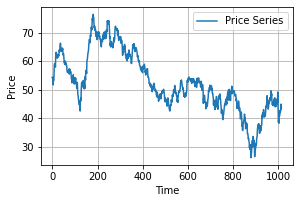

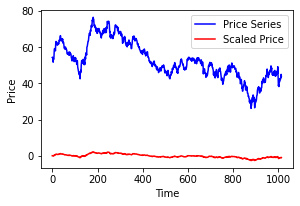

dfOil shape= (1014, 2).
dfOilPriceScaled shape= (1014, 1).
oilPX shape== (1000, 14, 1).
oilPY shape== (1000, 1).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


InternalError:  Blas GEMM launch failed : a.shape=(16, 100), b.shape=(100, 400), m=16, n=400, k=100
	 [[{{node sequential/lstm/while/body/_1/sequential/lstm/while/lstm_cell/MatMul_1}}]] [Op:__inference_train_function_3321]

Function call stack:
train_function


In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2s
from math import sqrt
import os

def plotCurve(x,y,xlable,ylabel,clabel):
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x,y,label=clabel)
    ax.set_xlabel(xlable)
    ax.set_ylabel(ylabel)
    plt.grid()
    ax.legend()
    plt.show()

def plotTwoCurves(x1,x2,y1,y2,xlable,ylabel,clabel1,clabel2):
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x1,y1,color='blue',label=clabel1)
    ax.plot(x2,y2,color='red',label=clabel2)
    ax.set_xlabel(xlable)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()


# os.chdir('change to current location')

dfOil=pd.read_csv('/home/jovyan/ECG/longht/Crude Oil WTI3.csv')
dfOil['Date']=pd.to_datetime(dfOil['Date'])
print(dfOil['Price'].head())

index1=range(0,dfOil['Date'].shape[0])

plotCurve(index1,dfOil['Price'],'Time','Price','Price Series')

dfOilPrice=dfOil['Price'].astype(float)

scaler=StandardScaler()
scaler=scaler.fit(dfOilPrice.values.reshape(-1, 1))
dfOilPriceScaled=scaler.transform(dfOilPrice.values.reshape(-1, 1))

plotTwoCurves(index1,index1,dfOil['Price'],dfOilPriceScaled,'Time','Price','Price Series','Scaled Price')

oilPX=[]
oilPY=[]

nextPrd=1
windSz=14

for i in range(windSz, len(dfOilPriceScaled)-nextPrd+1):    
    oilPX.append(dfOilPriceScaled[i-windSz:i])
    oilPY.append(dfOilPriceScaled[i+nextPrd-1:i+nextPrd,0])

oilPX,oilPY=np.array(oilPX),np.array(oilPY)

print('dfOil shape= {}.'.format(dfOil.shape))
print('dfOilPriceScaled shape= {}.'.format(dfOilPriceScaled.shape))
print('oilPX shape== {}.'.format(oilPX.shape))
print('oilPY shape== {}.'.format(oilPY.shape))

model=Sequential()
model.add(LSTM(100, activation='relu', input_shape=(oilPX.shape[1], oilPX.shape[2]), return_sequences=True))
model.add(LSTM(50, activation= 'relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(oilPY.shape[1]))

model.compile(optimizer='adam',loss='mse')

model.summary()

history=model.fit(oilPX,oilPY,epochs=5,batch_size=16, validation_split=0.1,verbose=1)

index2=range(0,len(history.history['loss']))
plotTwoCurves(index2,index2,history.history['loss'],history.history['val_loss'],'Epochs','Loss','Loss Series','Val_loss Series')

forecastD=60

predictedForDays=model.predict(oilPX[-forecastD:])
actualOilPForDays=dfOil['Price'][-forecastD:]

predictedForDaysInn=scaler.inverse_transform(predictedForDays)
index3=range(0,len(predictedForDaysInn))
plotTwoCurves(index3,index3,dfOil['Price'][-forecastD:],predictedForDaysInn,'Date','Price','Actual Oil Price','Predicted Oil Price')


index4=range(0,len(dfOil)-forecastD)
index5=range(len(dfOil)-forecastD,len(dfOil))
plotTwoCurves(index4,index5,dfOil['Price'][0:len(dfOil)-forecastD],predictedForDaysInn,'Date','Price','Actual Oil Price','Predicted Oil Price')

mae1=mae(actualOilPForDays,predictedForDaysInn)
mse1=mse(actualOilPForDays,predictedForDaysInn)
print(mse1)
rmse1=sqrt(mse1)
r2_score=r2s(actualOilPForDays,predictedForDaysInn)
print(r2_score)
n=forecastD
k=1
adjr=1-(((1-r2_score)*(n-1))/(n-k-1))
print(adjr)


In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Outputs some information on CUDA-enabled devices on your computer,
including current memory usage.

It's a port of https://gist.github.com/f0k/0d6431e3faa60bffc788f8b4daa029b1
from C to Python with ctypes, so it can run without compiling anything. Note
that this is a direct translation with no attempt to make the code Pythonic.
It's meant as a general demonstration on how to obtain CUDA device information
from Python without resorting to nvidia-smi or a compiled Python extension.

Author: Jan Schlüter
License: MIT (https://gist.github.com/f0k/63a664160d016a491b2cbea15913d549#gistcomment-3870498)
"""

import sys
import ctypes


# Some constants taken from cuda.h
CUDA_SUCCESS = 0
CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT = 16
CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_MULTIPROCESSOR = 39
CU_DEVICE_ATTRIBUTE_CLOCK_RATE = 13
CU_DEVICE_ATTRIBUTE_MEMORY_CLOCK_RATE = 36


def ConvertSMVer2Cores(major, minor):
    # Returns the number of CUDA cores per multiprocessor for a given
    # Compute Capability version. There is no way to retrieve that via
    # the API, so it needs to be hard-coded.
    # See _ConvertSMVer2Cores in helper_cuda.h in NVIDIA's CUDA Samples.
    return {(1, 0): 8,    # Tesla
            (1, 1): 8,
            (1, 2): 8,
            (1, 3): 8,
            (2, 0): 32,   # Fermi
            (2, 1): 48,
            (3, 0): 192,  # Kepler
            (3, 2): 192,
            (3, 5): 192,
            (3, 7): 192,
            (5, 0): 128,  # Maxwell
            (5, 2): 128,
            (5, 3): 128,
            (6, 0): 64,   # Pascal
            (6, 1): 128,
            (6, 2): 128,
            (7, 0): 64,   # Volta
            (7, 2): 64,
            (7, 5): 64,   # Turing
            (8, 0): 64,   # Ampere
            (8, 6): 128,
            (8, 7): 128,
            (8, 9): 128,  # Ada
            (9, 0): 128,  # Hopper
            }.get((major, minor), 0)


def main():
    libnames = ('libcuda.so', 'libcuda.dylib', 'nvcuda.dll', 'cuda.dll')
    for libname in libnames:
        try:
            cuda = ctypes.CDLL(libname)
        except OSError:
            continue
        else:
            break
    else:
        raise OSError("could not load any of: " + ' '.join(libnames))

    nGpus = ctypes.c_int()
    name = b' ' * 100
    cc_major = ctypes.c_int()
    cc_minor = ctypes.c_int()
    cores = ctypes.c_int()
    threads_per_core = ctypes.c_int()
    clockrate = ctypes.c_int()
    freeMem = ctypes.c_size_t()
    totalMem = ctypes.c_size_t()

    result = ctypes.c_int()
    device = ctypes.c_int()
    context = ctypes.c_void_p()
    error_str = ctypes.c_char_p()

    result = cuda.cuInit(0)
    if result != CUDA_SUCCESS:
        cuda.cuGetErrorString(result, ctypes.byref(error_str))
        print("cuInit failed with error code %d: %s" % (result, error_str.value.decode()))
        return 1
    result = cuda.cuDeviceGetCount(ctypes.byref(nGpus))
    if result != CUDA_SUCCESS:
        cuda.cuGetErrorString(result, ctypes.byref(error_str))
        print("cuDeviceGetCount failed with error code %d: %s" % (result, error_str.value.decode()))
        return 1
    print("Found %d device(s)." % nGpus.value)
    for i in range(nGpus.value):
        result = cuda.cuDeviceGet(ctypes.byref(device), i)
        if result != CUDA_SUCCESS:
            cuda.cuGetErrorString(result, ctypes.byref(error_str))
            print("cuDeviceGet failed with error code %d: %s" % (result, error_str.value.decode()))
            return 1
        print("Device: %d" % i)
        if cuda.cuDeviceGetName(ctypes.c_char_p(name), len(name), device) == CUDA_SUCCESS:
            print("  Name: %s" % (name.split(b'\0', 1)[0].decode()))
        if cuda.cuDeviceComputeCapability(ctypes.byref(cc_major), ctypes.byref(cc_minor), device) == CUDA_SUCCESS:
            print("  Compute Capability: %d.%d" % (cc_major.value, cc_minor.value))
        if cuda.cuDeviceGetAttribute(ctypes.byref(cores), CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, device) == CUDA_SUCCESS:
            print("  Multiprocessors: %d" % cores.value)
            print("  CUDA Cores: %s" % (cores.value * ConvertSMVer2Cores(cc_major.value, cc_minor.value) or "unknown"))
            if cuda.cuDeviceGetAttribute(ctypes.byref(threads_per_core), CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_MULTIPROCESSOR, device) == CUDA_SUCCESS:
                print("  Concurrent threads: %d" % (cores.value * threads_per_core.value))
        if cuda.cuDeviceGetAttribute(ctypes.byref(clockrate), CU_DEVICE_ATTRIBUTE_CLOCK_RATE, device) == CUDA_SUCCESS:
            print("  GPU clock: %g MHz" % (clockrate.value / 1000.))
        if cuda.cuDeviceGetAttribute(ctypes.byref(clockrate), CU_DEVICE_ATTRIBUTE_MEMORY_CLOCK_RATE, device) == CUDA_SUCCESS:
            print("  Memory clock: %g MHz" % (clockrate.value / 1000.))
        try:
            result = cuda.cuCtxCreate_v2(ctypes.byref(context), 0, device)
        except AttributeError:
            result = cuda.cuCtxCreate(ctypes.byref(context), 0, device)
        if result != CUDA_SUCCESS:
            cuda.cuGetErrorString(result, ctypes.byref(error_str))
            print("cuCtxCreate failed with error code %d: %s" % (result, error_str.value.decode()))
        else:
            try:
                result = cuda.cuMemGetInfo_v2(ctypes.byref(freeMem), ctypes.byref(totalMem))
            except AttributeError:
                result = cuda.cuMemGetInfo(ctypes.byref(freeMem), ctypes.byref(totalMem))
            if result == CUDA_SUCCESS:
                print("  Total Memory: %ld MiB" % (totalMem.value / 1024**2))
                print("  Free Memory: %ld MiB" % (freeMem.value / 1024**2))
            else:
                cuda.cuGetErrorString(result, ctypes.byref(error_str))
                print("cuMemGetInfo failed with error code %d: %s" % (result, error_str.value.decode()))
            cuda.cuCtxDetach(context)
    return 0


if __name__=="__main__":
    sys.exit(main())

Found 2 device(s).
Device: 0
  Name: Tesla P100-PCIE-16GB
  Compute Capability: 6.0
  Multiprocessors: 56
  CUDA Cores: 3584
  Concurrent threads: 114688
  GPU clock: 1328.5 MHz
  Memory clock: 715 MHz
cuCtxCreate failed with error code 2: out of memory
Device: 1
  Name: Tesla P100-PCIE-16GB
  Compute Capability: 6.0
  Multiprocessors: 56
  CUDA Cores: 3584
  Concurrent threads: 114688
  GPU clock: 1328.5 MHz
  Memory clock: 715 MHz
  Total Memory: 16276 MiB
  Free Memory: 7525 MiB


SystemExit: 0

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
